# ARMAX models



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
from cmdstanpy import CmdStanModel

In [3]:
df = pd.read_csv('data/armaxdata.csv')
df.head()

,datetime,Ti,Te,P
0,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
1,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890
3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786
4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637


Text(0.5, 0, 'Ti-Te')

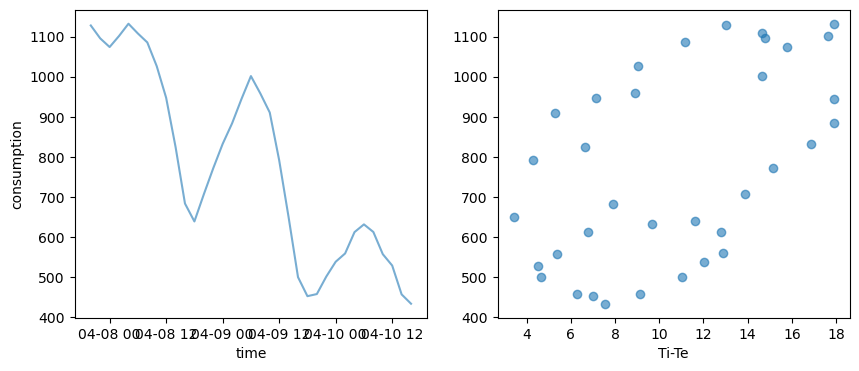

In [4]:
# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(pd.to_datetime(df['datetime']), df['P'], alpha=0.6)
axes[1].scatter(df['Ti']-df['Te'], df['P'], alpha=0.6)
axes[0].set_ylabel("consumption")
axes[0].set_xlabel("time")
axes[1].set_xlabel("Ti-Te")

There is clearly not a simple linear relationship between heating power and indoor-outdoor temperature difference, because of the building's inertia.

[Autoregressive models](timeseries_intro.md) (AR) are based on the idea that the current value of the series, $y_t$, can be explained as a function of $p$ past values, $y_{t−1}$, $y_{t−2}$, ..., $y_{t−p}$.

$$y_{t−1} = \beta_0 + \beta_1 y_{t−1} + \beta_2 y_{t−2} + ... + \beta_p y_{t−p} + \varepsilon_t$$

They are essentially linear regression models which take *lagged* copies of the dependent variable as explanatory variables. Other variables can be added, leading to the so-called ARX model (AR model with eXplanatory variables).

We wish to predict the heating power $P$ from its own previous values and other measurements. First, we augment the dataset with lagged versions of all its columns.